## Importing Libraries

In [660]:
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process, Merton_process, VG_process, Heston_process
from FMNM.BS_pricer import BS_pricer
from FMNM.Merton_pricer import Merton_pricer
from FMNM.VG_pricer import VG_pricer
from FMNM.Heston_pricer import Heston_pricer

import numpy as np
import pandas as pd
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.optimize as scpo
from functools import partial
from itertools import compress
import os
import warnings

warnings.filterwarnings("ignore")

#### Implied Volatility

In [661]:
def implied_volatility(price, S0, K, T, r, payoff="call", method="fsolve", disp=True):
    """Returns Implied volatility
    methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return price - BS.BlackScholes(payoff=payoff, S0=S0, K=K, T=T, r=r, sigma=vol)

    if method == "brent":
        x, r = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if r.converged == True:
            return x
    if method == "fsolve":
        X0 = [0.1, 0.5, 1, 3]  # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp == True:
        print("Strike", K)
    return -1

In [662]:
def implied_vol_minimize(price, S0, K, T, r, payoff="call", disp=True):
    """Returns Implied volatility by minimization"""

    n = 2  # must be even

    def obj_fun(vol):
        return (BS.BlackScholes(payoff=payoff, S0=S0, K=K, T=T, r=r, sigma=vol) - price) ** n

    res = scpo.minimize_scalar(obj_fun, bounds=(1e-15, 8), method="bounded")
    if res.success == True:
        return res.x
    if disp == True:
        print("Strike", K)
    return -1

In [663]:
data = pd.read_csv('path_of_csv')

In [664]:
data["SPREAD_CALL"] = data.ASK_CALL - data.BID_CALL
data["SPREAD_PUT"] = data.ASK_PUT - data.BID_PUT

,Unnamed: 0,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],...,IV_PUT,ASK_CALL,ASK_PUT,BID_CALL,BID_PUT,STRIKE,Underlying_Value,DAYS_TO_EXPIERY,SPREAD_CALL,SPREAD_PUT
98,98,1577998800,2020-01-02 16:00,2020-01-02,16.0,324.87,2020-09-30,1601496000,271.96,0.05536,...,0.00050,0.73,50.90,0.66,50.18,375.0,324.87,272,0.07,0.72
99,99,1577998800,2020-01-02 16:00,2020-01-02,16.0,324.87,2020-09-30,1601496000,271.96,0.04223,...,-0.00025,0.54,55.70,0.48,54.98,380.0,324.87,272,0.06,0.72
100,100,1577998800,2020-01-02 16:00,2020-01-02,16.0,324.87,2020-09-30,1601496000,271.96,0.03193,...,0.00026,0.39,60.65,0.35,59.93,385.0,324.87,272,0.04,0.72
101,101,1577998800,2020-01-02 16:00,2020-01-02,16.0,324.87,2020-09-30,1601496000,271.96,0.02406,...,0.00031,0.30,65.70,0.25,64.99,390.0,324.87,272,0.05,0.71
102,102,1577998800,2020-01-02 16:00,2020-01-02,16.0,324.87,2020-09-30,1601496000,271.96,0.01906,...,-0.00021,0.23,70.74,0.18,70.02,395.0,324.87,272,0.05,0.72


In [665]:
data['Midpoint_Call'] = (data['ASK_CALL'] + data['BID_CALL'])/2
data['Midpoint_Put'] = (data['ASK_PUT'] + data['BID_PUT'])/2

#### Volatility Smile

In [666]:
import yfinance as yf
date = data['date'][0]
r = yf.download('^TNX', date).Close[0]/100

[*********************100%%**********************]  1 of 1 completed


In [667]:
S0 = data['Underlying_Value'][0]
Days = data['DAYS_TO_EXPIERY'][0]
if (Days >= 30):
  T = Days/365
else:
  T = Days/252
opt_param = Option_param(S0=S0, K=S0, T=T, v0=0.04, exercise="European", payoff="call")
diff_param = Diffusion_process(r, sig=0.2)

In [668]:
BS = BS_pricer(opt_param, diff_param)

In [669]:
IV_call = data.apply(lambda x: implied_vol_minimize(x["Midpoint_Call"], S0, x["STRIKE"], T, r, payoff="call"), axis=1)
CALL = data.assign(IV_mid=IV_call.values)

In [670]:
IV_put = data.apply(
    lambda x: implied_vol_minimize(x["Midpoint_Put"], S0, x["STRIKE"], T, r, payoff="put", disp=False), axis=1
)
PUT = data.assign(IV_mid=IV_put.values)

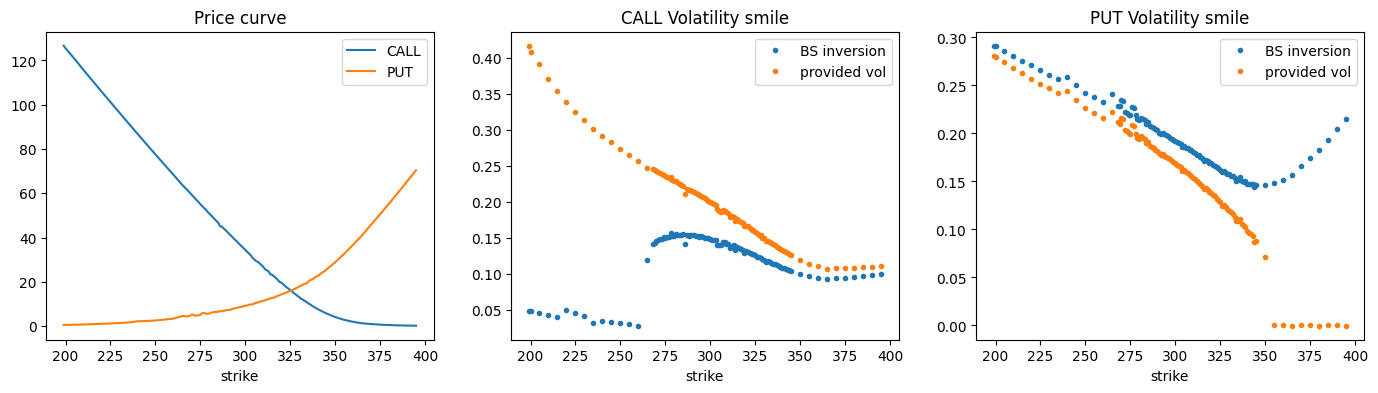

In [671]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(CALL.STRIKE, CALL.Midpoint_Call, "-", label="CALL")
ax1.plot(PUT.STRIKE, PUT.Midpoint_Put, "-", label="PUT")
ax2.plot(CALL.STRIKE, CALL.IV_mid, ".", label="BS inversion")
ax2.plot(CALL.STRIKE, CALL.IV_CALL, ".", label="provided vol")
ax3.plot(PUT.STRIKE, PUT.IV_mid, ".", label="BS inversion")
ax3.plot(PUT.STRIKE, PUT.IV_PUT, ".", label="provided vol")
ax1.set_title("Price curve")
ax2.set_title("CALL Volatility smile")
ax3.set_title("PUT Volatility smile")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [672]:
IV_call = data.apply(
    lambda x: implied_volatility(x["Midpoint_Call"], S0, x["STRIKE"], T, r, payoff="call", disp=False), axis=1
)
CALL = data.assign(IV_mid=IV_call.values)
IV_put = data.apply(lambda x: implied_volatility(x["Midpoint_Put"], S0, x["STRIKE"], T, r, payoff="put", disp=False), axis=1)
PUT = data.assign(IV_mid=IV_put.values)

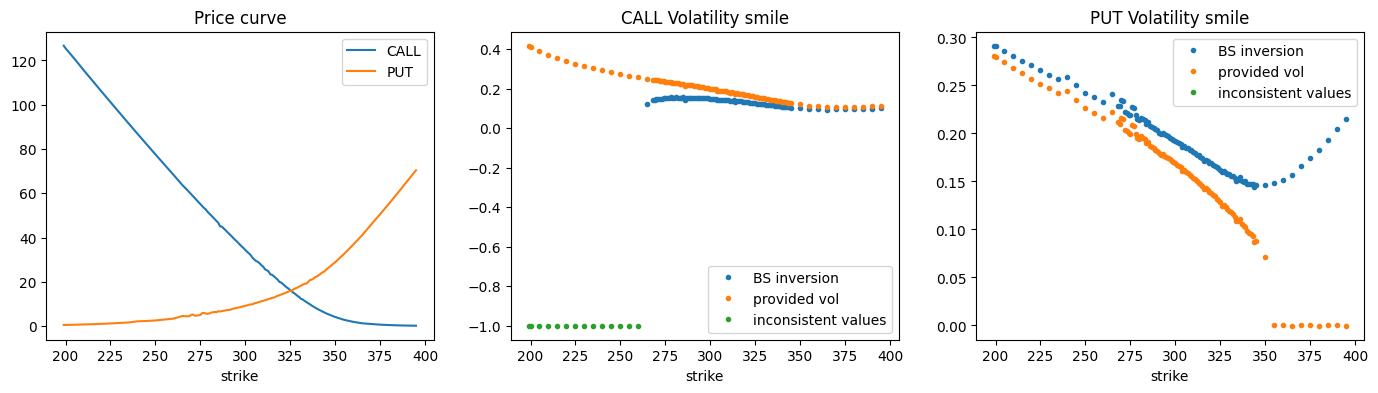

In [673]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(CALL.STRIKE, CALL.Midpoint_Call, "-", label="CALL")
ax1.plot(PUT.STRIKE, PUT.Midpoint_Put, "-", label="PUT")
ax2.plot(CALL[CALL.IV_mid != -1].STRIKE, CALL[CALL.IV_mid != -1].IV_mid, ".", label="BS inversion")
ax2.plot(CALL.STRIKE, CALL.IV_CALL, ".", label="provided vol")
ax2.plot(CALL[CALL.IV_mid == -1].STRIKE, CALL[CALL.IV_mid == -1].IV_mid, ".", label="inconsistent values")
ax3.plot(PUT[PUT.IV_mid != -1].STRIKE, PUT[PUT.IV_mid != -1].IV_mid, ".", label="BS inversion")
ax3.plot(PUT.STRIKE, PUT.IV_PUT, ".", label="provided vol")
ax3.plot(PUT[PUT.IV_mid == -1].STRIKE, PUT[PUT.IV_mid == -1].IV_mid, ".", label="inconsistent values")
ax1.set_title("Price curve")
ax2.set_title("CALL Volatility smile")
ax3.set_title("PUT Volatility smile")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [674]:
CALL = CALL[CALL.IV_mid != -1].reset_index(drop=True)
PUT = PUT[PUT.IV_mid != -1].reset_index(drop=True)

In [675]:
option_type = CALL
prices = option_type.Midpoint_Call.values
strikes = option_type.STRIKE.values
spreads = option_type.SPREAD_CALL.values
payoff = "call"

## MERTON parameters

In [677]:
def f_Mert(x, sig, lam, muJ, sigJ):
    Merton_param = Merton_process(r=r, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
    opt_param = Option_param(S0=S0, K=x, T=T, v0=0.04, exercise="European", payoff="call")
    Mert = Merton_pricer(opt_param, Merton_param)
    return Mert.closed_formula()


init_vals = [0.2, 1, -0.5, 0.2]
bounds = ([0, 0, -np.inf, 0], [2, np.inf, 5, 5])
params_Mert = scpo.curve_fit(f_Mert, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads)

## VG parameters

In [678]:
def f_VG(x, theta, sigma, kappa):
    VG_param = VG_process(r=r, theta=theta, sigma=sigma, kappa=kappa)
    opt_param = Option_param(S0=S0, K=x, T=T, v0=0.04, exercise="European", payoff="call")
    VG = VG_pricer(opt_param, VG_param)
    return VG.FFT(x)


init_vals = [-0.05, 0.2, 0.1]
bounds = ([-np.inf, 0, 0], [np.inf, 5, np.inf])
params_VG = scpo.curve_fit(f_VG, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads)

In [679]:
# Unconstrained problem
def f_Hest(x, rho, sigma, theta, kappa, v0):
    Heston_param = Heston_process(mu=r, rho=rho, sigma=sigma, theta=theta, kappa=kappa)
    opt_param = Option_param(S0=S0, K=x, T=T, v0=v0, exercise="European", payoff='call')
    Hest = Heston_pricer(opt_param, Heston_param)
    return Hest.FFT(x)


init_vals = [-0.6, 1.0, 0.04, 2.5, 0.04]
bounds = ([-1, 1e-15, 1e-15, 1e-15, 1e-15], [1, np.inf, 2, np.inf, 2])
params_Hest = scpo.curve_fit(
    f_Hest, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads, xtol=1e-4, max_nfev=1000)

In [680]:
init_vals = [-0.4, 1.1, 0.1, 0.6, 0.02]  # rho, sigma, theta, kappa, v0
# init_vals = [-0.7, 2.8, 0.7, 0.1, 0.02]  # alternative starting point

# bounds and constraint
bounds = ((-1, 1), (1e-15, np.inf), (1e-15, 50), (1e-15, 50), (1e-15, 10))


def Feller(x):
    """Feller condition"""
    return 2 * x[3] * x[2] - x[1] ** 2 - 1e-6


cons = {"fun": Feller, "type": "ineq"}  # inequality constraint


def least_sq(x, prices, strikes, spread):
    """Objective function"""
    Heston_param = Heston_process(mu=r, rho=x[0], sigma=x[1], theta=x[2], kappa=x[3])
    opt_param = Option_param(S0=S0, K=x, T=T, v0=x[4], exercise="European", payoff="call")
    Hest = Heston_pricer(opt_param, Heston_param)
    prices_calib = Hest.FFT(strikes)
    return np.sum(((prices_calib - prices) / spread) ** 2)


result = scpo.minimize(
    least_sq,
    x0=init_vals,
    args=(prices, strikes, spreads),
    method="SLSQP",
    bounds=bounds,
    constraints=cons,
    tol=1e-4,
    options={"maxiter": 500},
)
print(result.message)

Positive directional derivative for linesearch


In [681]:
opt_param_Feller = Option_param(S0=S0, K=data.STRIKE, T=T, v0=result.x[4], exercise="European", payoff='call')
opt_param = Option_param(S0=S0, K=data.STRIKE, T=T, v0=params_Hest[0][4], exercise="European", payoff='call')

Merton_param = Merton_process(
    r=r, sig=params_Mert[0][0], lam=params_Mert[0][1], muJ=params_Mert[0][2], sigJ=params_Mert[0][3]
)
Mert = Merton_pricer(opt_param, Merton_param)
VG_param = VG_process(r=r, theta=params_VG[0][0], sigma=params_VG[0][1], kappa=params_VG[0][2])
VG = VG_pricer(opt_param, VG_param)
Heston_param_Feller = Heston_process(mu=r, rho=result.x[0], sigma=result.x[1], theta=result.x[2], kappa=result.x[3])
Heston_param = Heston_process(
    mu=r, rho=params_Hest[0][0], sigma=params_Hest[0][1], theta=params_Hest[0][2], kappa=params_Hest[0][3]
)
Hest = Heston_pricer(opt_param, Heston_param)
Hest_Feller = Heston_pricer(opt_param_Feller, Heston_param_Feller)

In [682]:
Mert_pred = Mert.FFT(strikes)  # "pred" stays for "predicted"
VG_pred = VG.FFT(strikes)
Hest_pred = Hest.FFT(strikes)
Hest_Feller_pred = Hest_Feller.FFT(strikes)

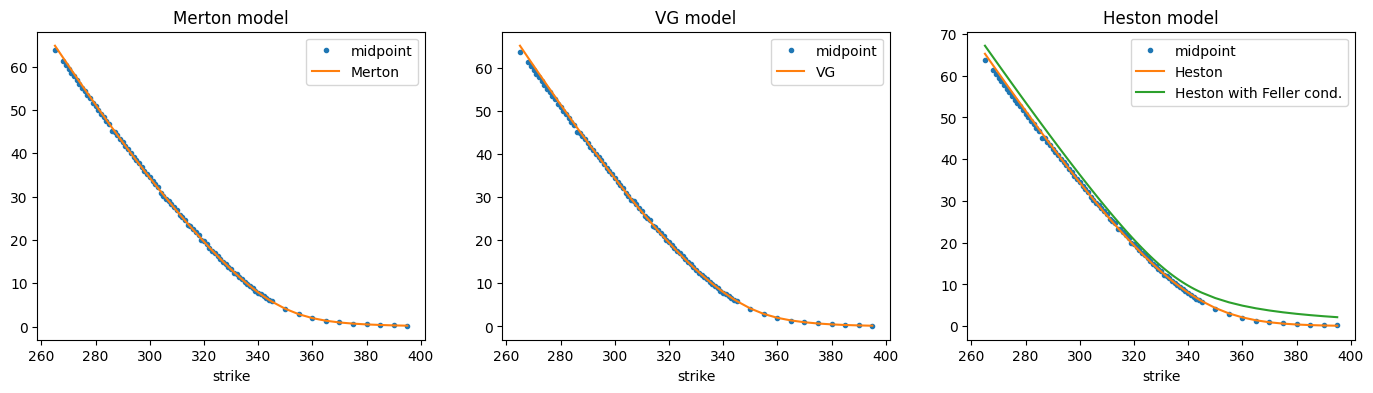

In [683]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(strikes, prices, ".", label="midpoint")
ax2.plot(strikes, prices, ".", label="midpoint")
ax3.plot(strikes, prices, ".", label="midpoint")
ax1.plot(strikes, Mert_pred, label="Merton")
ax2.plot(strikes, VG_pred, label="VG")
ax3.plot(strikes, Hest_pred, label="Heston")
ax3.plot(strikes, Hest_Feller_pred, label="Heston with Feller cond.")
ax1.set_title("Merton model")
ax2.set_title("VG model")
ax3.set_title("Heston model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

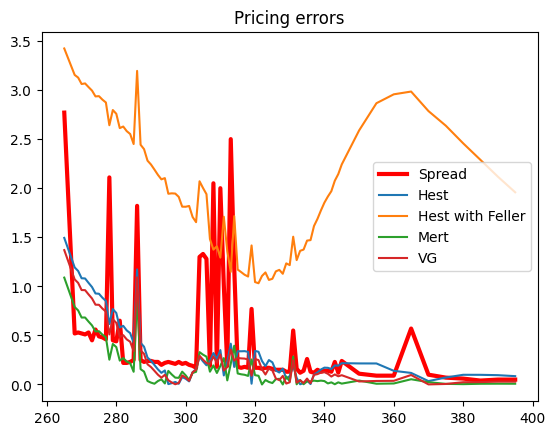

In [684]:
plt.plot(strikes, spreads, label="Spread", linewidth=3, color="red")
plt.plot(strikes, np.abs(prices - Hest_pred), label="Hest")
plt.plot(strikes, np.abs(prices - Hest_Feller_pred), label="Hest with Feller")
plt.plot(strikes, np.abs(prices - Mert_pred), label="Mert")
plt.plot(strikes, np.abs(prices - VG_pred), label="VG")
plt.title("Pricing errors")
plt.legend()
plt.show()

In [685]:
IV_VG = []
IV_Mert = []
IV_Hest = []
IV_Hest_F = []
for i, K in enumerate(strikes):
    IV_VG.append(implied_vol_minimize(VG_pred[i], S0=S0, K=K, T=T, r=r))
    IV_Mert.append(implied_vol_minimize(Mert_pred[i], S0=S0, K=K, T=T, r=r))
    IV_Hest.append(implied_vol_minimize(Hest_pred[i], S0=S0, K=K, T=T, r=r))
    IV_Hest_F.append(implied_vol_minimize(Hest_Feller_pred[i], S0=S0, K=K, T=T, r=r))

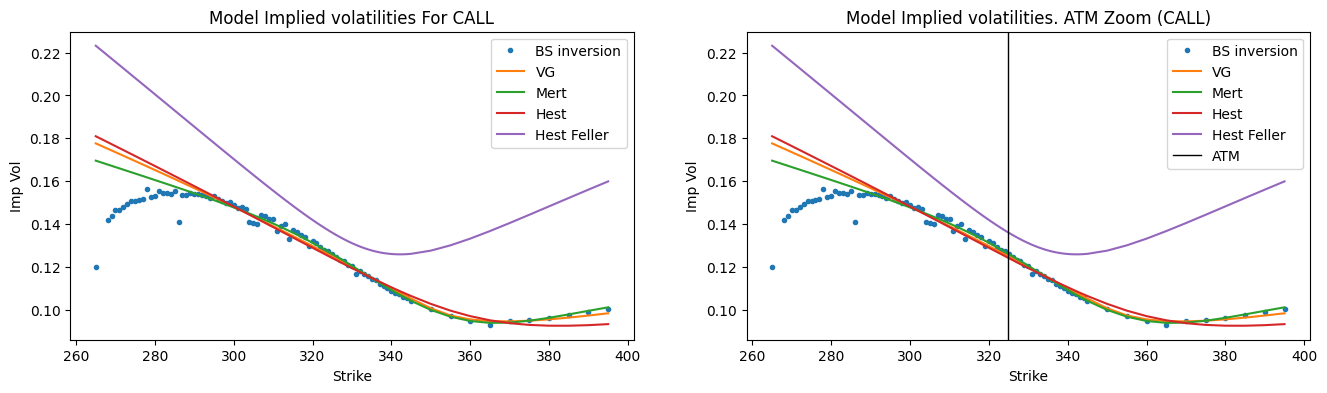

In [686]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(strikes, option_type.IV_mid, ".", label="BS inversion")
ax2.plot(strikes, option_type.IV_mid, ".", label="BS inversion")
ax1.plot(strikes, IV_VG, label="VG")
ax2.plot(strikes, IV_VG, label="VG")
ax1.plot(strikes, IV_Mert, label="Mert")
ax2.plot(strikes, IV_Mert, label="Mert")
ax1.plot(strikes, IV_Hest, label="Hest")
ax2.plot(strikes, IV_Hest, label="Hest")
ax1.plot(strikes, IV_Hest_F, label="Hest Feller")
ax2.plot(strikes, IV_Hest_F, label="Hest Feller")
# ax2.axis([23500, 26000, 0.125, 0.16])
ax2.axvline(S0, color="black", label="ATM", linewidth=1)
ax2.set_title("Model Implied volatilities. ATM Zoom (CALL)")
ax1.set_xlabel("Strike")
ax1.set_ylabel("Imp Vol")
ax1.set_title("Model Implied volatilities For CALL")
ax2.set_xlabel("Strike")
ax2.set_ylabel("Imp Vol")
ax1.legend()
ax2.legend()
plt.show()